# Neural network classifier for mushrooms

In [2]:
import os
import shutil
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.python.framework.config import list_physical_devices, set_memory_growth

In [3]:
# To fix "Image File is truncated" error during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [5]:
# Settings for displaying charts
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 12})

In [7]:
physical_devices = list_physical_devices('GPU')
print(f'Number of GPUs available: {len(physical_devices)}')

if len(physical_devices) > 0:
    set_memory_growth(physical_devices[0], True)

Number of GPUs available: 1


In [8]:
# TensorFlow settings
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 224
BATCH_SIZE = 64

## Loading and processing data

Classes found: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']
Number of classes: 9


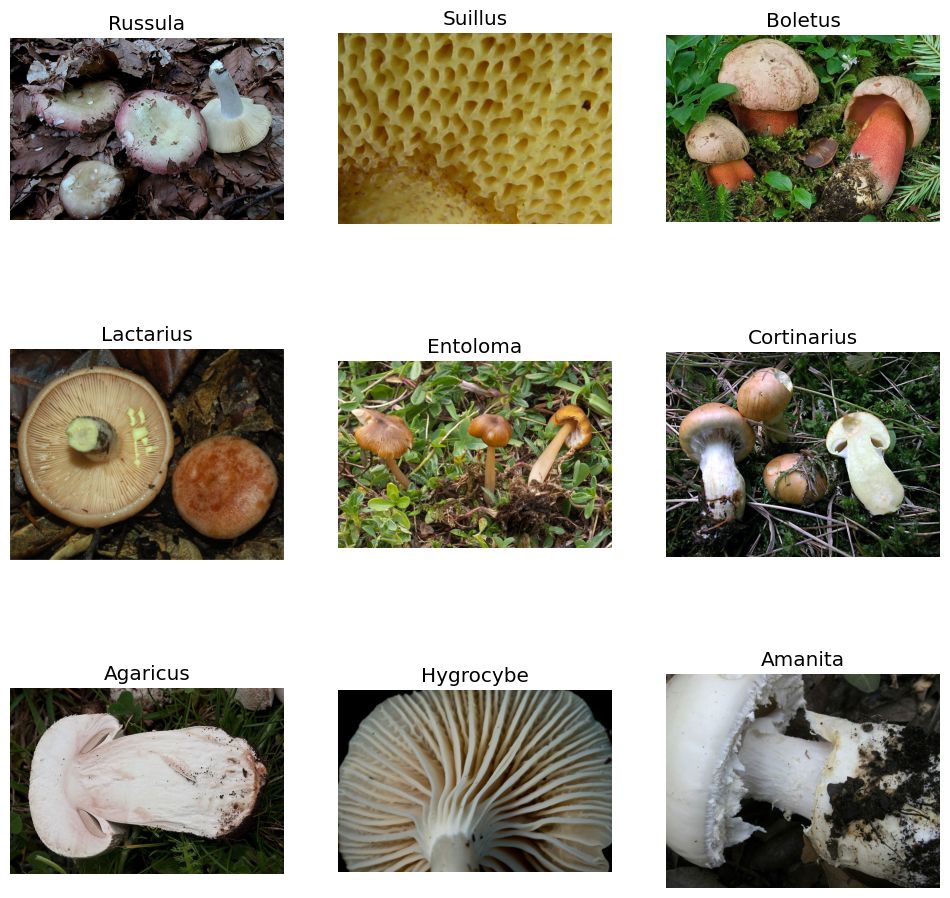

In [9]:
# Displaying examples from each class
nrows = 3
ncols = 3

pos = 0

train_path = "dataset/train"
val_path = "dataset/val"
test_path = "dataset/test"

classes = os.listdir('dataset/train')
classes.sort()
num_classes = len(classes)

print("Classes found:", classes)
print("Number of classes:", num_classes)

for subfolder in os.listdir(train_path):
    
    image_file = os.listdir(os.path.join(train_path, subfolder))[0]
    
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos += 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(train_path, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

In [10]:
# Create image datasets
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='dataset/train',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='dataset/val',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='dataset/test',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

Found 5367 images belonging to 9 classes.
Found 1007 images belonging to 9 classes.
Found 340 images belonging to 9 classes.


## Creating a model

In [11]:
# Pretrained EfficientNetB7 image classification model without final layers
# feature_model = tf.keras.applications.EfficientNetB7(weights='imagenet',
#                                                      include_top=False,
#                                                      input_shape=(IMG_SIZE, IMG_SIZE, 3),
#                                                      pooling='avg')

feature_model = tf.keras.applications.MobileNetV3Small(weights='imagenet',
                                                     include_top=False,
                                                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                     pooling='avg')
#feature_model.summary()

2023-11-25 03:32:13.705793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 03:32:13.706079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 03:32:13.706280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 03:32:13.926236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 03:32:13.926461: I tensorflow/compile

4334752/4334752 [==============================] - 0s 0us/step


In [12]:
# Construct a new model with the final dense layer for 9 classes
new_model = tf.keras.models.Sequential(
    [
        feature_model,
        tf.keras.layers.Dense(9, activation='softmax')
    ]
)

In [13]:
# Make all the layers from the original ResNet model untrainable
new_model.layers[0].trainable = False

In [14]:
# Metrics and optimizer
new_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [15]:
# Check the architecture of the new model
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 576)               939120    
 al)                                                             
                                                                 
 dense (Dense)               (None, 9)                 5193      
                                                                 
Total params: 944313 (3.60 MB)
Trainable params: 5193 (20.29 KB)
Non-trainable params: 939120 (3.58 MB)
_________________________________________________________________


In [16]:
# Callbacks to be exercised during training
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=10,
                                              restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.1,
                                                 mode='max',
                                                 cooldown=2,
                                                 patience=2,
                                                 min_lr=0)

In [17]:
# Train new model:

epoch = 50
history = new_model.fit(train_generator,
                        validation_data=valid_generator,
                        epochs=epoch,
                        steps_per_epoch=79,
                        validation_steps=16,
                        verbose=2,
                        callbacks=[reduce_lr, early_stop],
                        use_multiprocessing=True,
                        workers=2)

Epoch 1/50


2023-11-25 03:32:33.991804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-25 03:32:34.119903: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-25 03:32:34.487748: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-25 03:32:34.552933: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f993c041130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-25 03:32:34.552970: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-11-25 03:32:34.560339: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-25 03:32:34.629388: I ./tensorflow/compiler/jit/device_c

79/79 - 38s - loss: 1.6747 - accuracy: 0.4244 - val_loss: 1.3600 - val_accuracy: 0.5462 - lr: 0.0010 - 38s/epoch - 477ms/step
Epoch 2/50
79/79 - 33s - loss: 1.1928 - accuracy: 0.6037 - val_loss: 1.1676 - val_accuracy: 0.5978 - lr: 0.0010 - 33s/epoch - 412ms/step
Epoch 3/50
79/79 - 34s - loss: 1.0456 - accuracy: 0.6515 - val_loss: 1.0630 - val_accuracy: 0.6306 - lr: 0.0010 - 34s/epoch - 426ms/step
Epoch 4/50
79/79 - 33s - loss: 0.9538 - accuracy: 0.6782 - val_loss: 1.0024 - val_accuracy: 0.6495 - lr: 0.0010 - 33s/epoch - 424ms/step
Epoch 5/50
79/79 - 33s - loss: 0.8919 - accuracy: 0.7020 - val_loss: 0.9605 - val_accuracy: 0.6683 - lr: 0.0010 - 33s/epoch - 414ms/step
Epoch 6/50
79/79 - 31s - loss: 0.8438 - accuracy: 0.7238 - val_loss: 0.9411 - val_accuracy: 0.6743 - lr: 0.0010 - 31s/epoch - 389ms/step
Epoch 7/50
79/79 - 29s - loss: 0.8160 - accuracy: 0.7274 - val_loss: 0.9110 - val_accuracy: 0.6713 - lr: 0.0010 - 29s/epoch - 371ms/step
Epoch 8/50
79/79 - 34s - loss: 0.7749 - accuracy: 0.

# Displaying the results

In [18]:
loss, accuracy = new_model.evaluate(test_generator,
                                    steps=11, 
                                    verbose=2, 
                                    use_multiprocessing=True, 
                                    workers=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

11/11 - 4s - loss: 0.8134 - accuracy: 0.7030 - 4s/epoch - 380ms/step
Model performance on test images:
Accuracy = 0.7030302882194519
Loss = 0.8133543133735657


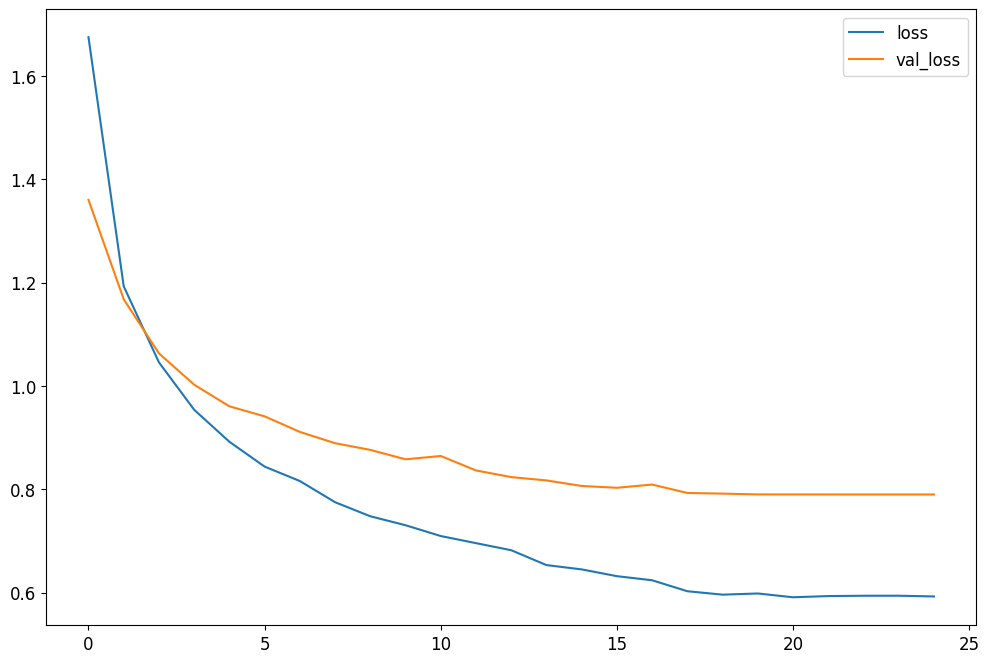

In [19]:
# Loss during training:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot();

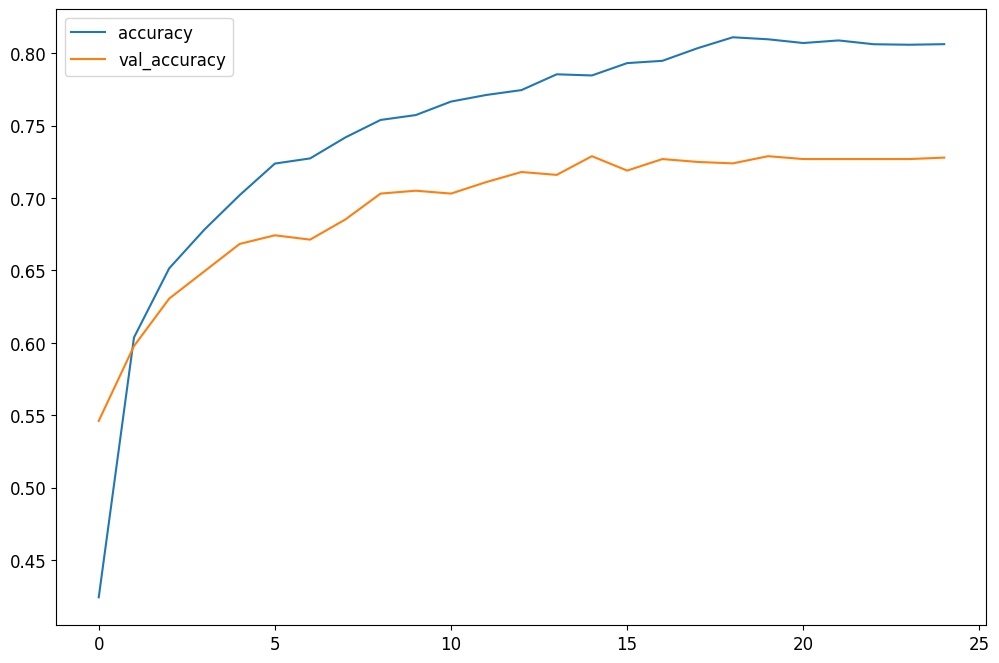

In [20]:
# Accuracy during training:
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [21]:
weight_name = 'weight/MobileNetV3Small_fungus'+ str(num_classes) +"_epoch" + str(epoch)

new_model.save(weight_name + '_final')

INFO:tensorflow:Assets written to: weight/MobileNetV3Small_fungus9_epoch50_final/assets


INFO:tensorflow:Assets written to: weight/MobileNetV3Small_fungus9_epoch50_final/assets


In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

with open(weight_name + ".tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpw17i5zdd/assets


INFO:tensorflow:Assets written to: /tmp/tmpw17i5zdd/assets
2023-11-25 03:50:33.610168: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-25 03:50:33.610223: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-25 03:50:33.610828: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpw17i5zdd
2023-11-25 03:50:33.624259: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-25 03:50:33.624291: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpw17i5zdd
2023-11-25 03:50:33.654014: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-11-25 03:50:33.666244: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-25 03:50:33.901053: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio